# K-means: California housing


## Notebook set-up

In [2]:
# Standard library imports
from pathlib import Path

# Core data science libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Custom helper functions for visualization and analysis
import functions as funcs

RANDOM_SEED = 315

## 1. Data loading

In this section, we load the California housing dataset from a remote URL, save a local copy for future use, and perform initial data inspection. We'll also filter the dataset to keep only the features needed for our clustering analysis: median income and geographic coordinates.

### 1.1. Load data from URL

In [3]:
# Load California housing data from remote CSV
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
data_df = pd.read_csv(url)

### 1.2. Save a local copy

In [4]:
data_df.to_csv("california_housing.csv", index=False)

### 1.3. Inspect

In [5]:
data_df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 1.4. Remove unnecessary features

In [7]:
# Select only location and median income features as specified in assignment
data_df = data_df[['MedInc', 'Latitude', 'Longitude']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     20640 non-null  float64
 1   Latitude   20640 non-null  float64
 2   Longitude  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


## 2. EDA

### 2.1. Feature distributions

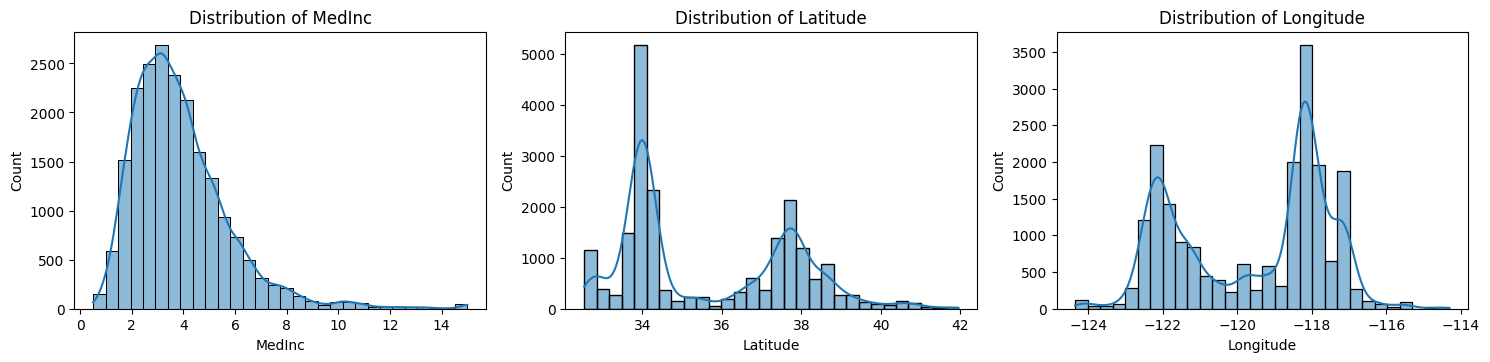

In [8]:

# Plot distributions of all numeric features
numeric_columns = data_df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

### 2.2. Feature correlations

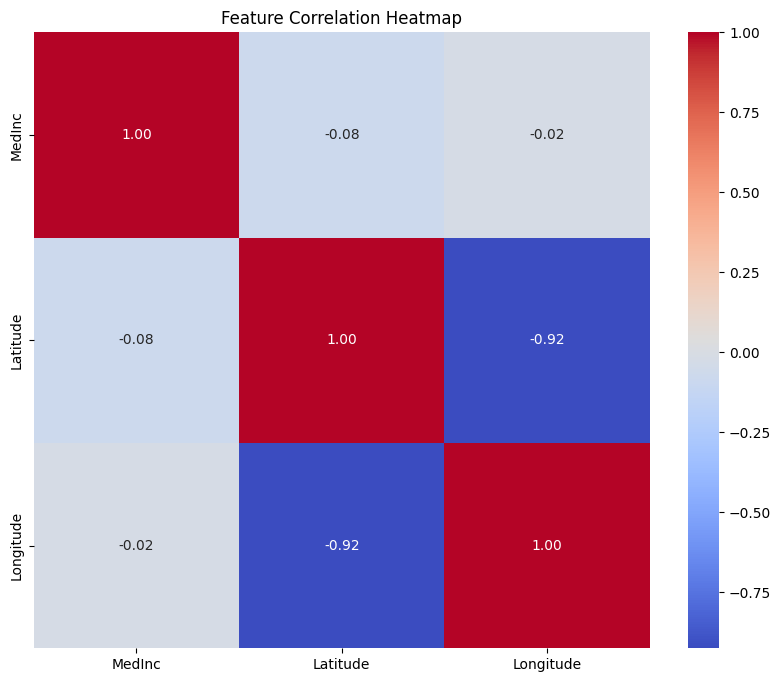

In [9]:
# Compute correlation matrix
corr_matrix = data_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


Latitude and Longitude have a strong negative correlation (-0.92):

This likely reflects California’s geographic shape — as you move west (longitude decreases), you may also be moving north or south (latitude changes consistently).

This is not a causal relationship, just a geographic one.

Median Income vs. Latitude: weak negative correlation (-0.08)

Slight tendency for income to be lower in northern latitudes — possibly linked to population or economic centers.

Median Income vs. Longitude: almost no correlation (-0.02)

Income levels appear fairly evenly distributed along the east–west axis of the state.

## 3. Data preparation

### 3.1. Train-test split

In [10]:
# Make the test dataset 20% of the data and the training data set 80%
# Define your feature columns explicitly
features = data_df.columns

# Split into features and target 
X = data_df[features]

# Train-test split
X_train, X_test = train_test_split(
    X,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     20640 non-null  float64
 1   Latitude   20640 non-null  float64
 2   Longitude  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


### 3.2. Feature scaling

In [12]:
# Scale the features so that they all have the same range - sklearn's MinMaxScaler() or StandardScaler() are good options here.

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the training data; transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 4. Clustering


### 4.1. Find clusters

In [13]:

# Choose the number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED)

# Fit the model to the scaled training data
kmeans.fit(X_train_scaled)

# Assign cluster labels to the training set
X_train['cluster'] = kmeans.labels_



### 4.2. Add cluster label to training data

In [14]:
# Make a copy of the training data to avoid modifying the original
training_df_with_clusters = X_train.copy()

# Add the cluster labels from X_train
training_df_with_clusters['cluster'] = X_train['cluster']

In [15]:
print(training_df_with_clusters.columns.tolist())



['MedInc', 'Latitude', 'Longitude', 'cluster']


In [16]:
# Create a copy of the original training data (unscaled) to hold cluster labels
training_df_with_clusters = X_train.copy()

# Add the cluster labels
training_df_with_clusters['cluster'] = kmeans.labels_


### 3.3. Plot results

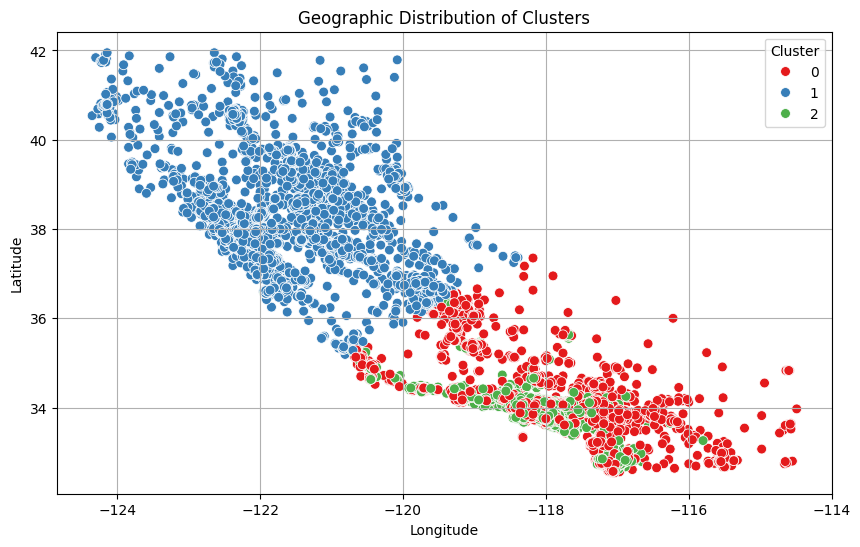

In [17]:

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=training_df_with_clusters,
    x='Longitude',
    y='Latitude',
    hue='cluster',
    palette='Set1',
    s=50
)
plt.title("Geographic Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## 5. Supervised classification model

In this final section, we build a supervised classification model to predict cluster membership based on the features alone. We'll train a Gradient Boosting Classifier using the cluster labels from K-means as our target variable, evaluate its performance through cross-validation, and test its accuracy on held-out data. This demonstrates how unsupervised clustering results can be used to create supervised learning models.

### 5.1. Features & labels

In [22]:
# Set up dataframes/list holding the features: MedInc, Latitude and Longitude and the 'label' - the cluster assigned by the KMeans model
df = training_df_with_clusters.copy()


### 5.2. Model training

In [23]:
# Train a classification model to predict the cluster label

# Define features and target
X = df[['MedInc', 'Latitude', 'Longitude']]
y = df['cluster']  

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

# Initialize the model
gb_clf = GradientBoostingClassifier(random_state=RANDOM_SEED)

# Train the model
gb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_clf.predict(X_test)

# Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 1.00


### 5.3. Cross-validation

In [24]:
# Cross validate the classification model

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gb_clf, X, y, cv=5)

# Output results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation: {cv_scores.std():.2f}")


Cross-Validation Accuracy Scores: [0.99666969 0.99697245 0.99788007 0.99848577 0.99606299]
Mean Accuracy: 1.00
Standard Deviation: 0.00


### 5.4. Model evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1438
           1       1.00      1.00      1.00      1354
           2       0.99      1.00      1.00       511

    accuracy                           1.00      3303
   macro avg       1.00      1.00      1.00      3303
weighted avg       1.00      1.00      1.00      3303



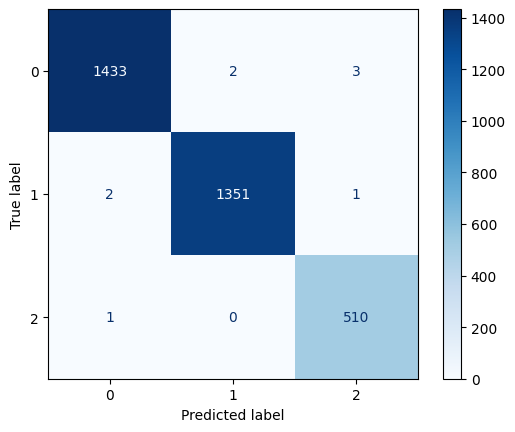

In [26]:
# Evaluate the classification model on the held-out test data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict the test set
y_pred = gb_clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_clf.classes_) 
disp.plot(cmap="Blues")

# Optional: add classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
